In [1]:
import numpy as np
from numpy import exp, sqrt, pi

import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad, quadrature, quad, nquad
import sys

sys.path.append("../Codes/")
from Hall1997 import *
from quad_utils import *
from angle_Hall1997 import *

In [2]:
sigma = 1
a = 1.5
theta = 0.3

upper_bdy = lambda t: a - theta * t
lower_bdy = lambda t: -a + theta * t

# collapse at a / theta
mu1, mu2, mu3, mu4 = 1, 1, 1, 1
T1, T2, T3, T4 = 0.8, 1, 0.5, 0.4 
t1, t2, t3, t4 = np.cumsum([T1, T2, T3, T4])
x0 = -0.7

p = lambda x, t, y, s, mu: density_vertical(x, mu=mu, a=a - theta * s, b=theta, x0=y, T=t - s, trunc_num=100)
fu = lambda t, y, s, mu: density_upper(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)
fl = lambda t, y, s, mu: density_lower(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)

In [3]:
# reference
eps = 5e-3
ts = np.linspace(eps, t4 - eps, 1000)

probu_list = []
probl_list = []
for t in ts:
    probu_list.append(fu(t, x0, 0, mu1))
    probl_list.append(fl(t, x0, 0, mu1))

In [4]:
t1s = np.linspace(eps, t1 - eps, 200)
t2s = np.linspace(t1 + eps, t2 - eps, 100)
t3s = np.linspace(t2 + eps, t3 - eps, 100)
t4s = np.linspace(t3 + eps, t4 - eps, 100)

In [5]:
# multi-dimensional Gauss-Legendre quadrature, in a wrapped function
# first stage, analytical
p1u_gaussfun_list, p1l_gaussfun_list = [], []
for t in t1s:
    p1u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=1))
    p1l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=-1))

# second stage, 1D integral
p2u_gaussfun_list, p2l_gaussfun_list = [], []
for t in t2s:
    p2u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1))
    p2l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=-1))
    
# third stage, 2D integral
p3u_gaussfun_list, p3l_gaussfun_list = [], []
for t in t3s:
    p3u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1))
    p3l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=-1))
    
# fourth stage, 3D integral
p4u_gaussfun_list, p4l_gaussfun_list = [], []
for t in t4s:
    p4u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1))
    p4l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=-1))

In [6]:
# sequential trapezoidal rule, flattened
# first stage, analytical
x1s = np.linspace(lower_bdy(t1), upper_bdy(t1), 100)
p1u_seq_list = []
p1l_seq_list = []
p1v_seq_list = []
for t in t1s:
    p1u_seq_list.append(fu(t, x0, 0, mu1))
    p1l_seq_list.append(fl(t, x0, 0, mu1))
for x1 in x1s:
    p1v_seq_list.append(p(x1, t1, x0, 0, mu1))
    
# second stage, 1D integral
t2s = np.linspace(t1 + eps, t2 - eps, 100)
x2s = np.linspace(lower_bdy(t2), upper_bdy(t2), 100)
p2u_seq_list = []
p2l_seq_list = []
p2v_seq_list = []
for t in t2s:
    # int p(x1, t1, x0, 0) * f(t, x1, t1) dx1
    result_u, result_l = 0, 0
    for i in range(1, len(x1s) - 1):
        result_u += p1v_seq_list[i] * fu(t, x1s[i], t1, mu2)
        result_l += p1v_seq_list[i] * fl(t, x1s[i], t1, mu2)
    result_u *= (x1s[1] - x1s[0])
    result_l *= (x1s[1] - x1s[0])
    p2u_seq_list.append(result_u)
    p2l_seq_list.append(result_l)
for x2 in x2s:
    # int p(x1, t1, x0, 0) * p(x2, t2, x1, t1) dx1
    result_v = 0
    for i in range(1, len(x1s) - 1):
        result_v += p1v_seq_list[i] * p(x2, t2, x1s[i], t1, mu2)
    result_v *= (x1s[1] - x1s[0])
    p2v_seq_list.append(result_v)

# third stage, 2D integral
t3s = np.linspace(t2 + eps, t3 - eps, 100)
x3s = np.linspace(lower_bdy(t3), upper_bdy(t3), 100)
p3u_seq_list = []
p3l_seq_list = []
p3v_seq_list = []
for t in t3s:
    result_u, result_l = 0, 0
    for i in range(1, len(x2s) - 1):
        result_u += p2v_seq_list[i] * fu(t, x2s[i], t2, mu3)
        result_l += p2v_seq_list[i] * fl(t, x2s[i], t2, mu3)
    result_u *= (x2s[1] - x2s[0])
    result_l *= (x2s[1] - x2s[0])
    p3u_seq_list.append(result_u)
    p3l_seq_list.append(result_l)
for x3 in x3s:
    result_v = 0
    for i in range(1, len(x2s) - 1):
        result_v += p2v_seq_list[i] * p(x3, t3, x2s[i], t2, mu3)
    result_v *= (x2s[1] - x2s[0])
    p3v_seq_list.append(result_v)
    
# fourth stage, 3D integral
t4s = np.linspace(t3 + eps, t4 - eps, 100)
x4s = np.linspace(lower_bdy(t4), upper_bdy(t4), 100)
p4u_seq_list = []
p4l_seq_list = []
p4v_seq_list = []
for t in t4s:
    result_u, result_l = 0, 0
    for i in range(1, len(x3s) - 1):
        result_u += p3v_seq_list[i] * fu(t, x3s[i], t3, mu4)
        result_l += p3v_seq_list[i] * fl(t, x3s[i], t3, mu4)
    result_u *= (x3s[1] - x3s[0])
    result_l *= (x3s[1] - x3s[0])
    p4u_seq_list.append(result_u)
    p4l_seq_list.append(result_l)
for x4 in x4s:
    result_v = 0
    for i in range(1, len(x3s) - 1):
        result_v += p3v_seq_list[i] * p(x4, t4, x3s[i], t3, mu4)
    result_v *= (x3s[1] - x3s[0])
    p4v_seq_list.append(result_v)

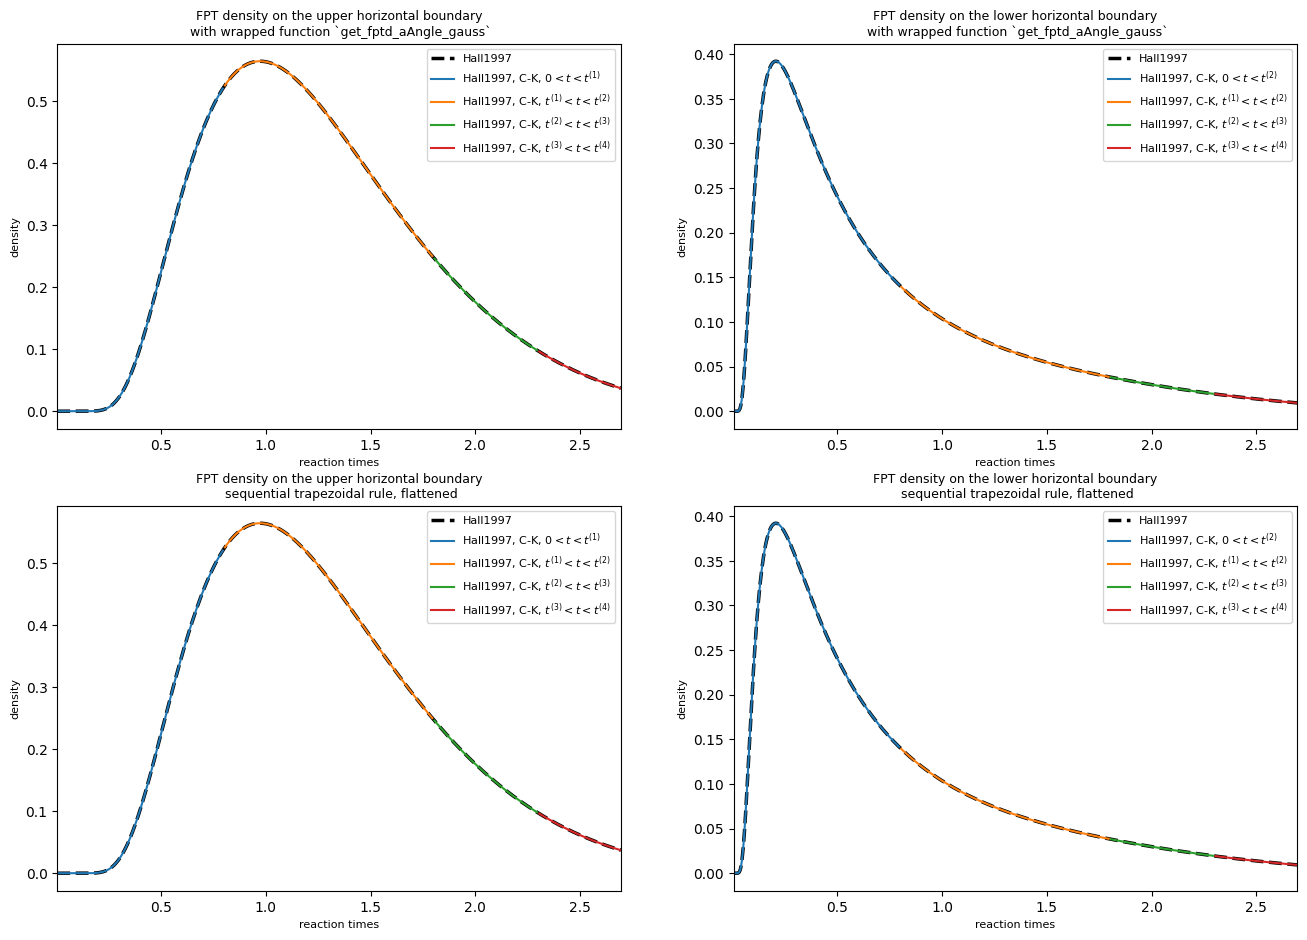

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(16, 11), dpi=100)
ax[0, 0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0, 0].plot(t1s, p1u_gaussfun_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0, 0].plot(t2s, p2u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0, 0].plot(t3s, p3u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0, 0].plot(t4s, p4u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0, 0].legend(fontsize=8)
ax[0, 0].set_title("FPT density on the upper horizontal boundary\n with wrapped function `get_fptd_aAngle_gauss`", fontsize=9)
ax[0, 0].set_xlabel("reaction times", fontsize=8)
ax[0, 0].set_ylabel("density", fontsize=8)
ax[0, 0].autoscale(tight=True, axis="x")

ax[0, 1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0, 1].plot(t1s, p1l_gaussfun_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[0, 1].plot(t2s, p2l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0, 1].plot(t3s, p3l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0, 1].plot(t4s, p4l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0, 1].legend(fontsize=8)
ax[0, 1].set_title("FPT density on the lower horizontal boundary\n with wrapped function `get_fptd_aAngle_gauss`", fontsize=9)
ax[0, 1].set_xlabel("reaction times", fontsize=8)
ax[0, 1].set_ylabel("density", fontsize=8)
ax[0, 1].autoscale(tight=True, axis="x")

ax[1, 0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1, 0].plot(t1s, p1u_seq_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[1, 0].plot(t2s, p2u_seq_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1, 0].plot(t3s, p3u_seq_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1, 0].plot(t4s, p4u_seq_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1, 0].legend(fontsize=8)
ax[1, 0].set_title("FPT density on the upper horizontal boundary\n sequential trapezoidal rule, flattened", fontsize=9)
ax[1, 0].set_xlabel("reaction times", fontsize=8)
ax[1, 0].set_ylabel("density", fontsize=8)
ax[1, 0].autoscale(tight=True, axis="x")

ax[1, 1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1, 1].plot(t1s, p1l_seq_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[1, 1].plot(t2s, p2l_seq_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1, 1].plot(t3s, p3l_seq_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1, 1].plot(t4s, p4l_seq_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1, 1].legend(fontsize=8)
ax[1, 1].set_title("FPT density on the lower horizontal boundary\n sequential trapezoidal rule, flattened", fontsize=9)
ax[1, 1].set_xlabel("reaction times", fontsize=8)
ax[1, 1].set_ylabel("density", fontsize=8)
ax[1, 1].autoscale(tight=True, axis="x")

plt.show()

In [8]:
%timeit get_fptd_aAngle_gauss(t=0+T1/2, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_gauss(t=t1+T2/2, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_gauss(t=t2+T3/2, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_gauss(t=t3+T4/2, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1)

23.8 µs ± 468 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
706 µs ± 3.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.28 ms ± 63.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.75 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit get_fptd_aAngle_seq(t=0+T1/2, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_seq(t=t1+T2/2, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_seq(t=t2+T3/2, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1)
%timeit get_fptd_aAngle_seq(t=t3+T4/2, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1)

24.9 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.18 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
548 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.05 s ± 36.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### piecewise constant drift rate

In [54]:
sigma = 1
a = 1.5
theta = 0.3

upper_bdy = lambda t: a - theta * t
lower_bdy = lambda t: -a + theta * t

# collapse at a / theta = 5
mu1, mu2, mu3, mu4, mu5 = 1, -0.2, 0.5, 0.1, -1
T1, T2, T3, T4, T5 = 1, 1.5, 1, 0.5, 1
t1, t2, t3, t4, t5 = np.cumsum([T1, T2, T3, T4, T5])
x0 = -0.5

p = lambda x, t, y, s, mu: density_vertical(x, mu=mu, a=a - theta * s, b=theta, x0=y, T=t - s, trunc_num=100)
fu = lambda t, y, s, mu: density_upper(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)
fl = lambda t, y, s, mu: density_lower(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)

In [55]:
eps = 1e-3
t1s = np.linspace(eps, t1 - eps, 200)
t2s = np.linspace(t1 + eps, t2 - eps, 100)
t3s = np.linspace(t2 + eps, t3 - eps, 100)
t4s = np.linspace(t3 + eps, t4 - eps, 100)
t5s = np.linspace(t4 + eps, t5 - eps, 100)

In [56]:
# multi-dimensional Gauss-Legendre quadrature, in a wrapped function
# first stage, analytical
p1u_gaussfun_list, p1l_gaussfun_list = [], []
for t in t1s:
    p1u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=1))
    p1l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1], t_list=[], a=a, theta=theta, x0=x0, bdy=-1))

# second stage, 1D integral
p2u_gaussfun_list, p2l_gaussfun_list = [], []
for t in t2s:
    p2u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1))
    p2l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2], t_list=[t1], a=a, theta=theta, x0=x0, bdy=-1))
    
# third stage, 2D integral
p3u_gaussfun_list, p3l_gaussfun_list = [], []
for t in t3s:
    p3u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1))
    p3l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=-1))
    
# fourth stage, 3D integral
p4u_gaussfun_list, p4l_gaussfun_list = [], []
for t in t4s:
    p4u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1))
    p4l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=-1))

# fifth stage, 4D integral
p5u_gaussfun_list, p5l_gaussfun_list = [], []
for t in t5s:
    p5u_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4, mu5], t_list=[t1, t2, t3, t4], a=a, theta=theta, x0=x0, bdy=1))
    p5l_gaussfun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu1, mu2, mu3, mu4, mu5], t_list=[t1, t2, t3, t4], a=a, theta=theta, x0=x0, bdy=-1))

In [57]:
# sequential trapezoidal rule, flattened
# first stage, analytical
x1s = np.linspace(lower_bdy(t1), upper_bdy(t1), 100)
p1u_seq_list = []
p1l_seq_list = []
p1v_seq_list = []
for t in t1s:
    p1u_seq_list.append(fu(t, x0, 0, mu1))
    p1l_seq_list.append(fl(t, x0, 0, mu1))
for x1 in x1s:
    p1v_seq_list.append(p(x1, t1, x0, 0, mu1))
    
# second stage, 1D integral
t2s = np.linspace(t1 + eps, t2 - eps, 100)
x2s = np.linspace(lower_bdy(t2), upper_bdy(t2), 100)
p2u_seq_list = []
p2l_seq_list = []
p2v_seq_list = []
for t in t2s:
    # int p(x1, t1, x0, 0) * f(t, x1, t1) dx1
    result_u, result_l = 0, 0
    for i in range(1, len(x1s) - 1):
        result_u += p1v_seq_list[i] * fu(t, x1s[i], t1, mu2)
        result_l += p1v_seq_list[i] * fl(t, x1s[i], t1, mu2)
    result_u *= (x1s[1] - x1s[0])
    result_l *= (x1s[1] - x1s[0])
    p2u_seq_list.append(result_u)
    p2l_seq_list.append(result_l)
for x2 in x2s:
    # int p(x1, t1, x0, 0) * p(x2, t2, x1, t1) dx1
    result_v = 0
    for i in range(1, len(x1s) - 1):
        result_v += p1v_seq_list[i] * p(x2, t2, x1s[i], t1, mu2)
    result_v *= (x1s[1] - x1s[0])
    p2v_seq_list.append(result_v)

# third stage, 2D integral
t3s = np.linspace(t2 + eps, t3 - eps, 100)
x3s = np.linspace(lower_bdy(t3), upper_bdy(t3), 100)
p3u_seq_list = []
p3l_seq_list = []
p3v_seq_list = []
for t in t3s:
    result_u, result_l = 0, 0
    for i in range(1, len(x2s) - 1):
        result_u += p2v_seq_list[i] * fu(t, x2s[i], t2, mu3)
        result_l += p2v_seq_list[i] * fl(t, x2s[i], t2, mu3)
    result_u *= (x2s[1] - x2s[0])
    result_l *= (x2s[1] - x2s[0])
    p3u_seq_list.append(result_u)
    p3l_seq_list.append(result_l)
for x3 in x3s:
    result_v = 0
    for i in range(1, len(x2s) - 1):
        result_v += p2v_seq_list[i] * p(x3, t3, x2s[i], t2, mu3)
    result_v *= (x2s[1] - x2s[0])
    p3v_seq_list.append(result_v)
    
# fourth stage, 3D integral
t4s = np.linspace(t3 + eps, t4 - eps, 100)
x4s = np.linspace(lower_bdy(t4), upper_bdy(t4), 100)
p4u_seq_list = []
p4l_seq_list = []
p4v_seq_list = []
for t in t4s:
    result_u, result_l = 0, 0
    for i in range(1, len(x3s) - 1):
        result_u += p3v_seq_list[i] * fu(t, x3s[i], t3, mu4)
        result_l += p3v_seq_list[i] * fl(t, x3s[i], t3, mu4)
    result_u *= (x3s[1] - x3s[0])
    result_l *= (x3s[1] - x3s[0])
    p4u_seq_list.append(result_u)
    p4l_seq_list.append(result_l)
for x4 in x4s:
    result_v = 0
    for i in range(1, len(x3s) - 1):
        result_v += p3v_seq_list[i] * p(x4, t4, x3s[i], t3, mu4)
    result_v *= (x3s[1] - x3s[0])
    p4v_seq_list.append(result_v)
    
# fifth stage, 4D integral
t5s = np.linspace(t4 + eps, t5 - eps, 100)
x5s = np.linspace(lower_bdy(t5), upper_bdy(t5), 100)
p5u_seq_list = []
p5l_seq_list = []
p5v_seq_list = []
for t in t5s:
    result_u, result_l = 0, 0
    for i in range(1, len(x4s) - 1):
        result_u += p4v_seq_list[i] * fu(t, x4s[i], t4, mu5)
        result_l += p4v_seq_list[i] * fl(t, x4s[i], t4, mu5)
    result_u *= (x4s[1] - x4s[0])
    result_l *= (x4s[1] - x4s[0])
    p5u_seq_list.append(result_u)
    p5l_seq_list.append(result_l)
for x5 in x5s:
    result_v = 0
    for i in range(1, len(x4s) - 1):
        result_v += p4v_seq_list[i] * p(x5, t5, x4s[i], t4, mu5)
    result_v *= (x4s[1] - x4s[0])
    p5v_seq_list.append(result_v)

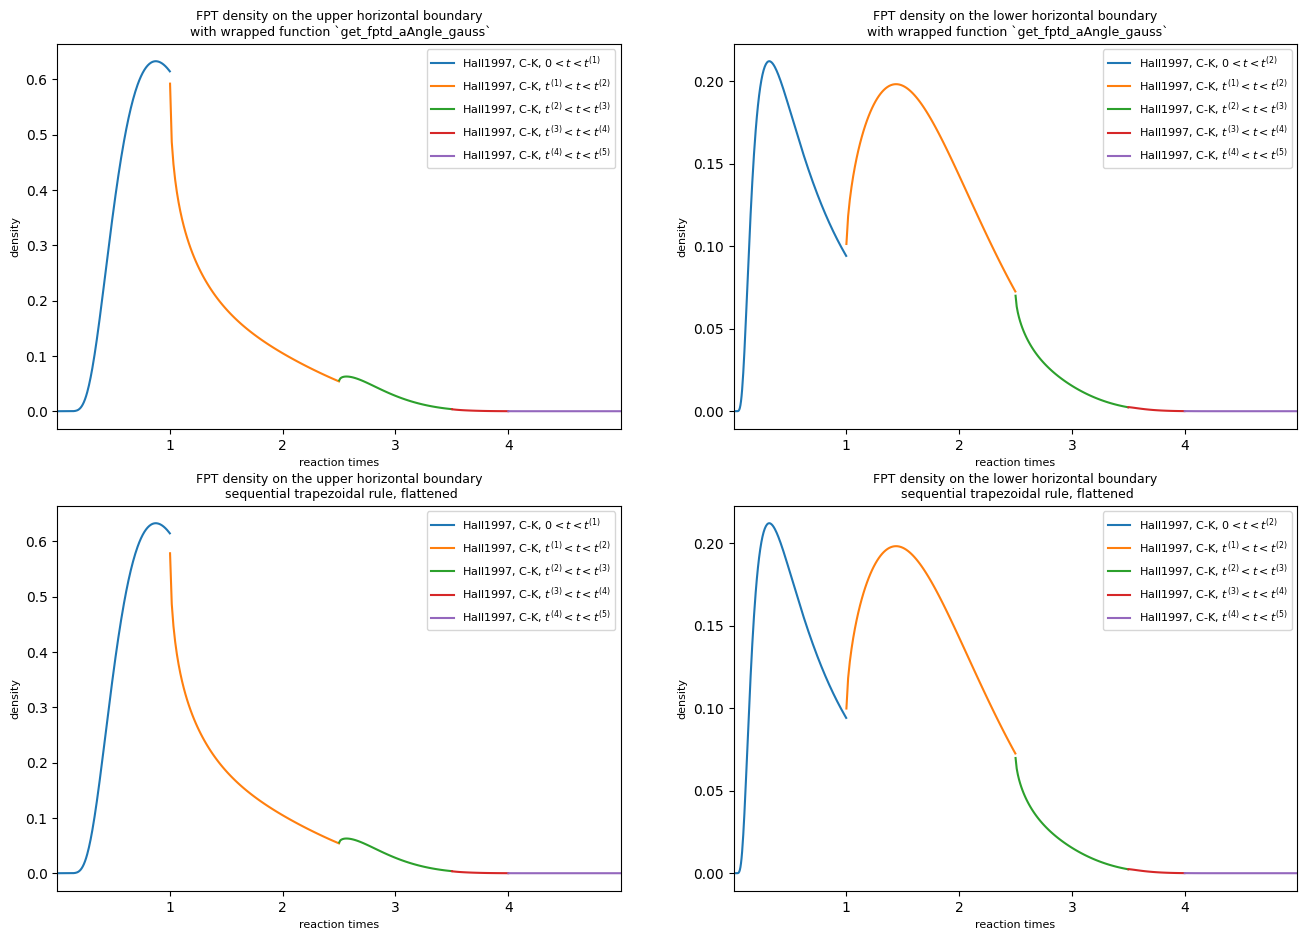

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(16, 11), dpi=100)
# ax[0, 0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0, 0].plot(t1s, p1u_gaussfun_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0, 0].plot(t2s, p2u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0, 0].plot(t3s, p3u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0, 0].plot(t4s, p4u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0, 0].plot(t5s, p5u_gaussfun_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[0, 0].legend(fontsize=8)
ax[0, 0].set_title("FPT density on the upper horizontal boundary\n with wrapped function `get_fptd_aAngle_gauss`", fontsize=9)
ax[0, 0].set_xlabel("reaction times", fontsize=8)
ax[0, 0].set_ylabel("density", fontsize=8)
ax[0, 0].autoscale(tight=True, axis="x")

# ax[0, 1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0, 1].plot(t1s, p1l_gaussfun_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[0, 1].plot(t2s, p2l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0, 1].plot(t3s, p3l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0, 1].plot(t4s, p4l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0, 1].plot(t5s, p5l_gaussfun_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[0, 1].legend(fontsize=8)
ax[0, 1].set_title("FPT density on the lower horizontal boundary\n with wrapped function `get_fptd_aAngle_gauss`", fontsize=9)
ax[0, 1].set_xlabel("reaction times", fontsize=8)
ax[0, 1].set_ylabel("density", fontsize=8)
ax[0, 1].autoscale(tight=True, axis="x")

# ax[1, 0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1, 0].plot(t1s, p1u_seq_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[1, 0].plot(t2s, p2u_seq_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1, 0].plot(t3s, p3u_seq_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1, 0].plot(t4s, p4u_seq_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1, 0].plot(t5s, p5u_seq_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[1, 0].legend(fontsize=8)
ax[1, 0].set_title("FPT density on the upper horizontal boundary\n sequential trapezoidal rule, flattened", fontsize=9)
ax[1, 0].set_xlabel("reaction times", fontsize=8)
ax[1, 0].set_ylabel("density", fontsize=8)
ax[1, 0].autoscale(tight=True, axis="x")

# ax[1, 1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1, 1].plot(t1s, p1l_seq_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[1, 1].plot(t2s, p2l_seq_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1, 1].plot(t3s, p3l_seq_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1, 1].plot(t4s, p4l_seq_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1, 1].plot(t5s, p5l_seq_list, label="Hall1997, C-K, " + "$t^{(4)}<t<t^{(5)}$")
ax[1, 1].legend(fontsize=8)
ax[1, 1].set_title("FPT density on the lower horizontal boundary\n sequential trapezoidal rule, flattened", fontsize=9)
ax[1, 1].set_xlabel("reaction times", fontsize=8)
ax[1, 1].set_ylabel("density", fontsize=8)
ax[1, 1].autoscale(tight=True, axis="x")

plt.show()

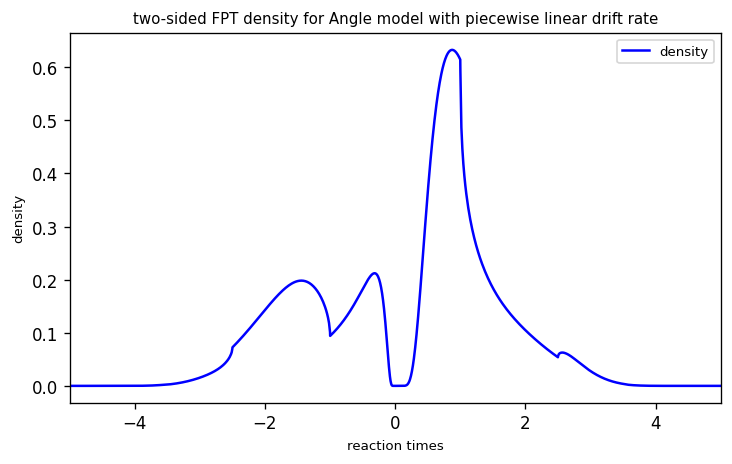

In [59]:
ts = np.hstack((t1s, t2s, t3s, t4s, t5s))
pu_gaussfun_all_list = np.hstack((
        p1u_gaussfun_list,
        p2u_gaussfun_list,
        p3u_gaussfun_list,
        p4u_gaussfun_list,
        p5u_gaussfun_list,
    )
)
pl_gaussfun_all_list = np.hstack(
    (
        p1l_gaussfun_list,
        p2l_gaussfun_list,
        p3l_gaussfun_list,
        p4l_gaussfun_list,
        p5l_gaussfun_list,
    )
)

ts_all = np.hstack((-ts[::-1], ts))
p_gaussfun_all_list = np.hstack((pl_gaussfun_all_list[::-1], pu_gaussfun_all_list))

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=120)
ax.plot(ts_all, p_gaussfun_all_list, c="blue", label="density")
ax.legend(fontsize=8)
ax.set_title(
    "two-sided FPT density for Angle model with piecewise linear drift rate", fontsize=9
)
ax.set_xlabel("reaction times", fontsize=8)
ax.set_ylabel("density", fontsize=8)
ax.autoscale(tight=True, axis="x")

plt.show()

In [60]:
np.trapz(p_gaussfun_all_list, ts_all)

1.0003139046057656